# Dataset

The dataset was taken from Aryabhatta Research Institute of Observational Sciences (ARIES), Nainital, India. The images were captured by the in-house 1.3m telescope of the observatory situated in Devasthal, Nainital, India. The original images captured were 2kx2k in size which was reduced to 64x64 cutouts from the images to isolate the sources in a single image.

For labelling the images, image segmentation was used to identify the sources in the image, and finally the center coordinates of the found sources were queried with the SDSS database to give a label corresponding to each 64x64 cutout.

This dataset is generated from scratch using the real-world data. We are using this dataset to train and compare various machine learning models to classify stellar sources like stars and galaxies in the telescope images.

# Importing Libraries

In [1]:
# Importing the libraries used in this notebook
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Loading Dataset

In [2]:
def load_dataset(dataset_pth):

    '''
    parameters
    dataset_pth => The path of the dataset directory

    returns 
    img_pths => Array containing the path to the dataset images
    img_labels => Array containing the labels to the corresponding dataset images
    class_list => List of classes which are enumerated in the img_labels array
    '''

    img_pths = []
    img_labels = []
    class_list = []
    
    classes = os.listdir(dataset_pth)
    for index, class_name in enumerate(classes):
        class_pth = os.path.join(dataset_pth, class_name)
        img_names = os.listdir(class_pth)
        class_list.append(class_name)
        for img in img_names:
            img_pth = os.path.join(class_pth, img)
            img_pths.append(img_pth)
            img_labels.append(index)

    return img_pths, img_labels, class_list

In [3]:
img_pths, img_labels, class_list = load_dataset("./dataset")

In [4]:
print(f"No of images path in the img_pths: {len(img_pths)}")
print(f"No of labels in the img_labels: {len(img_labels)}")
print(f"No of Classes in the class_list: {len(class_list)}")

No of images path in the img_pths: 3986
No of labels in the img_labels: 3986
No of Classes in the class_list: 2


In [5]:
class_list

['galaxy', 'star']

# Data Preprocessing

Size of each image in the dataset: (64, 64)


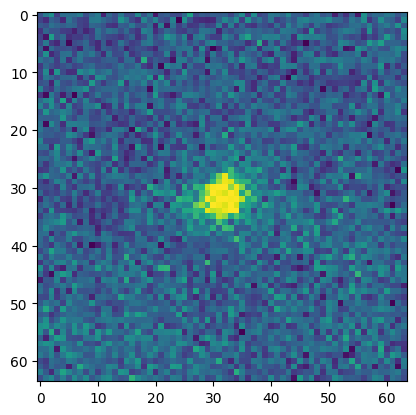

In [6]:
image = cv2.imread(img_pths[0], cv2.IMREAD_GRAYSCALE)
print(f"Size of each image in the dataset: {image.shape}")

image = np.array(image)
plt.imshow(image)

In [8]:
def process_dataset(img_pths):

    '''
    parameters
    img_pths => Array containing the paths to the dataset images

    returns
    img_data => The projected data of the image dataset along axis 0 and axis 1 combined
    '''

    img_data = []
    for img_pth in img_pths:
        processed_values = []
        image = cv2.imread(img_pth, cv2.IMREAD_GRAYSCALE)
        image = np.array(image)/255
        processed_values.extend(np.sum(image, axis=0))
        processed_values.extend(np.sum(image, axis=1))
        img_data.append(processed_values)

    return img_data

In [9]:
x_data = process_dataset(img_pths)
y_data = img_labels

In [10]:
print(len(x_data), len(y_data))

3986 3986


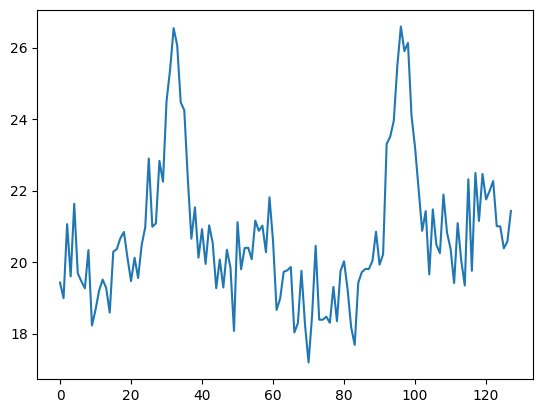

In [11]:
plt.plot(x_data[0])

In [12]:
def shuffle_dataset(data, labels):

    '''
    parameters
    data => The dataset containing the projected images
    labels => The labels of the data

    returns 
    X => shuffled dataset of data
    y => shuffled labels but preserving the mapping between data and labels
    '''

    temp = list(zip(data, labels))
    np.random.shuffle(temp)
    X, y = zip(*temp)

    return X, y

In [13]:
X, y = shuffle_dataset(x_data, y_data)

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Exploratory Data Analysis

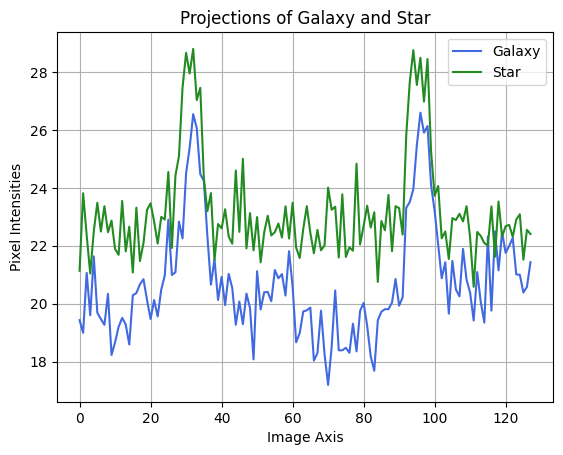

In [15]:
plt.plot(x_data[0], 'royalblue',label="Galaxy")
plt.plot(x_data[-1], 'forestgreen',label="Star")
plt.legend()
plt.title("Projections of Galaxy and Star")
plt.xlabel("Image Axis")
plt.ylabel("Pixel Intensities")
plt.grid('on')
plt.savefig("images/projection_galaxy_star.png")

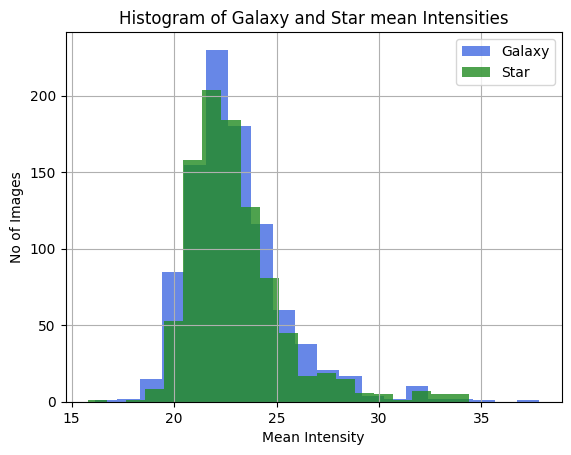

In [16]:
galaxy_mean_intensities = []
star_mean_intensities = []

no_galaxy = len(os.listdir("dataset/galaxy"))
no_star = len(os.listdir("dataset/star"))

for i in range(no_galaxy):
    galaxy_mean_intensities.append(np.mean(x_data[i]))

for i in range(no_galaxy, 2*no_galaxy):
    star_mean_intensities.append(np.mean(x_data[i]))

plt.hist(galaxy_mean_intensities, color='royalblue',label="Galaxy", bins=20, alpha=0.8)
plt.hist(star_mean_intensities, color='forestgreen',label="Star", bins=20, alpha=0.8)
plt.legend()
plt.title("Histogram of Galaxy and Star mean Intensities")
plt.xlabel("Mean Intensity")
plt.ylabel("No of Images")
plt.grid('on')
plt.savefig("images/hist_galaxy_star_intensity.png")


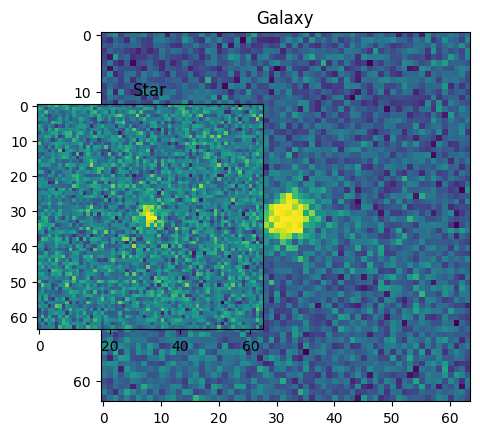

In [17]:
fig = plt.figure()
fig.add_subplot(1, 1, 1)
galaxy_image = cv2.imread(img_pths[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(galaxy_image)
plt.title("Galaxy")
fig.add_subplot(1, 2, 1)
star_image = cv2.imread(img_pths[-4], cv2.IMREAD_GRAYSCALE)
plt.imshow(star_image)
plt.title("Star")
plt.savefig("images/Galaxy_Star_comparison.png")

# Support Vector Machines

In [18]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

svm_clf = make_pipeline(StandardScaler(), svm.SVC())
svm_clf.fit(x_train, y_train)

svm_predictions = svm_clf.predict(x_test)
score = svm_clf.score(x_test, y_test)
print(f"The accuracy of svm: {score}")

cm = confusion_matrix(y_test, svm_predictions)
print(cm)

The accuracy of svm: 0.7869674185463659
[[  6 169]
 [  1 622]]


# Regression

In [38]:
from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression(fit_intercept=True, solver='lbfgs', max_iter=1000)
logistic_regression_model.fit(x_train, y_train)

logistic_regression_pred = logistic_regression_model.predict(x_test)
logistic_regression_score = logistic_regression_model.score(x_test, y_test)

print(f"The accuracy of Linear Regression Model: {logistic_regression_score}")

logistic_regression_cm = confusion_matrix(y_test, logistic_regression_pred)
print(logistic_regression_cm)

The accuracy of Linear Regression Model: 0.7694235588972431
[[ 33 142]
 [ 42 581]]


# Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

Gaussian Naive Bayes

In [30]:
model_gaussian_NB = GaussianNB()
model_gaussian_NB.fit(x_train, y_train)

y_gaussian_pred = model_gaussian_NB.predict(x_test)
multinomial_NB_score = model_gaussian_NB.score(x_test, y_test)

print(f"The accuracy of Gaussian Naive Bayes: {multinomial_NB_score}")

gaussian_NB_cm = confusion_matrix(y_test, y_gaussian_pred)
print(gaussian_NB_cm)


The accuracy of Gaussian Naive Bayes: 0.6829573934837093
[[ 43 132]
 [121 502]]


Multinomial Naive Bayes

In [31]:
model_multinomial_NB = MultinomialNB()
model_multinomial_NB.fit(x_train, y_train)

y_multinomial_pred = model_multinomial_NB.predict(x_test)
multinomial_NB_score = model_multinomial_NB.score(x_test, y_test)

print(f"The accuracy of Multinomial Naive Bayes: {multinomial_NB_score}")

gaussian_NB_cm = confusion_matrix(y_test, y_multinomial_pred)
print(gaussian_NB_cm)

The accuracy of Multinomial Naive Bayes: 0.7293233082706767
[[ 33 142]
 [ 74 549]]


# Random Forrest

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree_model = DecisionTreeClassifier()
bag_model = BaggingClassifier(tree_model, n_estimators=100, max_samples=0.8, random_state=1)
bag_model.fit(x_train, y_train)

tree_pred = bag_model.predict(x_test)
tree_score = bag_model.score(x_test, y_test)

print(f"The accuracy of Random Forrest Classifier: {tree_score}")

tree_cm = confusion_matrix(y_test, tree_pred)
print(tree_cm)

The accuracy of Random Forrest Classifier: 0.7919799498746867
[[ 21 154]
 [ 12 611]]


# K nearest neighbour classifier

In [48]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model = KNeighborsClassifier(n_neighbors=2)
KNN_model.fit(x_train, y_train)

KNN_pred = KNN_model.predict(x_test)
KNN_score = KNN_model.score(x_test, y_test)

print(f"The accuracy of KNN: {KNN_score}")

KNN_cm = confusion_matrix(y_test, KNN_pred)
print(KNN_cm)

The accuracy of KNN: 0.7017543859649122
[[ 85  90]
 [148 475]]


# Accuracy Plots